In [ ]:
## Install library
!pip install tensorflow-hub
!pip install tensorflow-text

### Import Library

In [1]:
import os
import csv
import time
import json
import emoji
import fasttext
import numpy as np
import pandas as pd
import string
import json
import pickle
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from datetime import date

from sklearn.model_selection import train_test_split
from sklearn.metrics import (f1_score,
                             precision_score,
                             recall_score, 
                             accuracy_score)

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

### Load Dataset

In [3]:
# Define variabel
trainset_path = './Dataset/train_dataset.csv'
testset_path = './Dataset/test_dataset.csv'

train_df = pd.read_csv(trainset_path)
test_df = pd.read_csv(testset_path)

train_df = train_df.fillna('unknown')
test_df = test_df.fillna('unknown')


In [4]:
len(train_df['LABEL'].unique())

41

In [5]:
train_df

,TEXT,LABEL
0,stomach pain acidity ulcers on tongue vomiting...,gerd
1,chills fatigue cough high fever sweating malai...,pneumonia
2,vomiting headache nausea spinning movements lo...,vertigo-paroymsal--positional-vertigo
3,weight loss restlessness lethargy irregular su...,diabetes
4,skin rash pus filled pimples blackheads scurring,acne
...,...,...
3439,vomiting indigestion loss of appetite abdomina...,peptic-ulcer-diseae
3440,chills vomiting sweating headache nausea diarr...,malaria
3441,skin rash joint pain skin peeling silver like ...,psoriasis
3442,joint pain vomiting fatigue high fever yellowi...,hepatitis-e


In [6]:
# Split train & test data
X_train, X_val, y_train, y_val = train_test_split(
                                          train_df['TEXT'],
                                          train_df['LABEL'], 
                                          test_size=0.2,
                                          stratify=train_df["LABEL"],
                                          random_state = 42
    )

In [7]:
X_test = test_df['TEXT']
y_test = test_df['LABEL']

In [8]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_val = le.fit_transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

### Create Tensorflow Bert Model from Tensorflow Hub

In [19]:
# Build neural network architecture
tf.keras.backend.clear_session()


text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/2",
    trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 128].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 128].
output = tf.keras.layers.Dropout(0.2, name="dropout")(pooled_output)
output = tf.keras.layers.Dense(41, activation='softmax', name="output")(output)


model = tf.keras.Model(text_input, output)

In [20]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy(name="accuracy")

In [21]:
model.compile(optimizer="adam",
                         loss=loss,
                         metrics=metrics)

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['input_1[0][0]']                
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

### Training Tensorflow Bert Model

In [23]:
#Callback
callback = EarlyStopping(
    monitor='val_accuracy',
    verbose=1,
    patience=2,
    restore_best_weights=True
)

In [24]:
# Fit model
# tf.config.run_functions_eagerly(True)

history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[callback],
                    epochs=10)

Epoch 1/10
87/87 [==============================] - 123s 1s/step - loss: 3.0068 - accuracy: 0.1597 - val_loss: 1.6413 - val_accuracy: 0.5733
Epoch 2/10
87/87 [==============================] - 104s 1s/step - loss: 0.9172 - accuracy: 0.7652 - val_loss: 0.1867 - val_accuracy: 0.9855
Epoch 3/10
87/87 [==============================] - 104s 1s/step - loss: 0.1462 - accuracy: 0.9869 - val_loss: 0.0685 - val_accuracy: 0.9942
Epoch 4/10
87/87 [==============================] - 101s 1s/step - loss: 0.2073 - accuracy: 0.9604 - val_loss: 0.1227 - val_accuracy: 0.9710
Epoch 5/10
87/87 [==============================] - 99s 1s/step - loss: 0.1277 - accuracy: 0.9757 - val_loss: 0.0406 - val_accuracy: 0.9971
Epoch 6/10
87/87 [==============================] - 106s 1s/step - loss: 0.0595 - accuracy: 0.9924 - val_loss: 0.0188 - val_accuracy: 0.9956
Epoch 7/10
87/87 [==============================] - 102s 1s/step - loss: 0.0250 - accuracy: 0.9982 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 8/10
87/

In [25]:
# evaluate the model with test data
model.evaluate(X_test, y_test, verbose=1)

47/47 [==============================] - 15s 320ms/step - loss: 0.0115 - accuracy: 1.0000


[0.011538316495716572, 1.0]

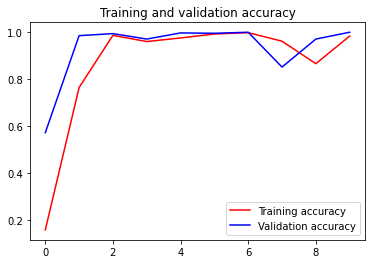

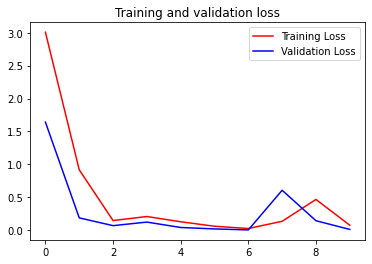

In [26]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Save Tensorflow Bert Model

In [27]:
import numpy as np

model.save('model/model-tensorflow-bert.hub')

# np.save('model/classes_encoder.npy', le.classes_)

INFO:tensorflow:Assets written to: model/model-tensorflow-bert.hub\assets


INFO:tensorflow:Assets written to: model/model-tensorflow-bert.hub\assets


### Testing Bert Model

In [28]:
np.array(X_train[0])

array('stomach pain acidity ulcers on tongue vomiting cough chest pain',
      dtype='<U63')

In [29]:
# Classify custom sample

sentences = [
            "stomach pain acidity ulcers on tongue",
            ]

sentences = np.array(sentences, dtype='object')
result = le.inverse_transform(np.argmax(model.predict(sentences), axis=-1))[0]
proba =  np.max(model.predict(sentences))
print(f"{result} : {proba}\n")

1/1 [==============================] - 0s 42ms/step
gerd : 0.9975273013114929



In [30]:
preds = tf.math.top_k(model.predict(sentences), k=3)
preds

1/1 [==============================] - 0s 168ms/step


TopKV2(values=<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[9.9752730e-01, 6.8415771e-04, 3.7385337e-04]], dtype=float32)>, indices=<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[16, 15, 39]])>)

In [31]:
preds[0][0].numpy().tolist()

[0.9975273013114929, 0.0006841577123850584, 0.0003738533705472946]

In [32]:
preds[1][0].numpy()

array([16, 15, 39])

In [33]:
preds = le.inverse_transform(preds[1][0].numpy())

In [34]:
preds

array(['gerd', 'gastroenteritis', 'varicose-veins'], dtype=object)

In [35]:
text = np.array(['itching'], dtype='object')
pred = model.predict(text)
preds = tf.math.top_k(pred, k=3)
list_predictions = le.inverse_transform(preds[1][0].numpy())
list_score = preds[0][0].numpy().tolist()

1/1 [==============================] - 0s 42ms/step


In [36]:
list_predictions

array(['jaundice', 'chronic-cholestasis', 'fungal-infection'],
      dtype=object)

In [37]:
list_score

[0.9295939803123474, 0.03960622102022171, 0.016750629991292953]

### Test Load Bert Model

In [38]:
load_model = hub.KerasLayer("./model/model-tensorflow-bert.hub")

In [42]:
result = le.inverse_transform(np.argmax(load_model(['itching']), axis=-1))[0]
proba =  np.max(model.predict(sentences))
print(f"{result} : {proba}\n")

1/1 [==============================] - 0s 44ms/step
jaundice : 0.9975273013114929

